<a href="https://colab.research.google.com/github/kimtaeho07/CS155-MP1/blob/main/KaggleVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MCE and Friends

Project steps:


1.   Data exploration


*   Plot features
*   Remove hashed features
*   Organize data matrix
*   Calculate prevalence rate
*   Training size vs. test size







2. Data processing and building training/validation/test sets


*   Validation and test sets are typically the same size
*   Shuffle dataset
*   Check that the prevalence in each set is similar to the original, otherwise consider subsampling or oversampling
*   Normalize/scale variables if needed
*   Assign data location cluster ID based on K-means clustering of lat/long data
      *   Multiple K-means outputs (different number of k clusters)



3. Try different classification models

*   Random Forest
*   Decision trees
*   Gradient boosting
*   Logistic regression
*   Neural net
      *   Batch normalization
*   Ensemble selection
*   Want a probability outcome



4. Model selection and validation


*   Learning curves
*   Bias-variance tradeoff



5. Hyperparameter tuning


*   Random grid search (Look into using a package)



In [18]:
# Import libraries here
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [ ]:
# Upload data as pandas df's
!wget https://github.com/lakiAgigar/Caltech-CS155-2021/raw/main/projects/project1/WILDFIRES_TEST.zip
!wget https://github.com/lakigigar/Caltech-CS155-2021/raw/main/projects/project1/WILDFIRES_TRAIN.zip

!unzip WILDFIRES_TEST.zip
!unzip WILDFIRES_TRAIN.zip

--2021-02-07 11:02:46--  https://github.com/lakiAgigar/Caltech-CS155-2021/raw/main/projects/project1/WILDFIRES_TEST.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-02-07 11:02:47 ERROR 404: Not Found.

--2021-02-07 11:02:47--  https://github.com/lakigigar/Caltech-CS155-2021/raw/main/projects/project1/WILDFIRES_TRAIN.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project1/WILDFIRES_TRAIN.zip [following]
--2021-02-07 11:02:47--  https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project1/WILDFIRES_TRAIN.

In [3]:
# Put csv data into pandas. Prevents from double downloading
train_df = pd.read_csv('WILDFIRES_TRAIN.csv', index_col='id')
test_df = pd.read_csv('WILDFIRES_TEST.csv', index_col='id')

In [4]:
# What the training data looks like
train_df

,LATITUDE,LONGITUDE,STATE,DISCOVERY_TIME,FIRE_SIZE,FIPS_NAME,FIPS_CODE,SOURCE_REPORTING_UNIT_NAME,DATE,LABEL
id,,,,,,,,,,
0,38.205000,-120.335000,CA,130.0,0.10,NaN,NaN,Stanislaus National Forest,1992-01-01,1
1,33.813100,-85.104300,GA,1115.0,1.17,Haralson,143.0,Georgia Forestry Commission,1992-01-01,4
2,32.201000,-82.498700,GA,1600.0,0.07,Montgomery,209.0,Georgia Forestry Commission,1992-01-01,2
3,32.509300,-81.708600,GA,1215.0,4.40,Bulloch,31.0,Georgia Forestry Commission,1992-01-01,4
4,33.663889,-116.171944,CA,NaN,0.20,NaN,NaN,CDF - Riverside Unit,1992-01-01,2
...,...,...,...,...,...,...,...,...,...,...
285377,32.359105,-82.893909,GA,NaN,0.25,Laurens,175.0,"GAS Ogeechee District, McRae Office",2009-12-30,4
285378,38.346342,-120.855472,CA,1031.0,0.10,NaN,NaN,Amador-El Dorado Unit,2009-12-30,2
285379,32.780596,-82.742433,GA,NaN,0.01,Johnson,167.0,"GAS Oconee District, Milledgeville Office",2009-12-30,2


In [5]:
# What the testing data looks like
test_df

,LATITUDE,LONGITUDE,STATE,DISCOVERY_TIME,FIRE_SIZE,FIPS_NAME,FIPS_CODE,SOURCE_REPORTING_UNIT_NAME,DATE
id,,,,,,,,,
285382,34.346944,-117.442222,CA,1605.0,0.20,San Bernardino,71.0,San Bernardino National Forest,2010-01-01
285383,34.020390,-116.179970,CA,1545.0,0.10,NaN,NaN,Joshua Tree National Monument,2010-01-01
285384,38.068611,-120.276667,CA,1200.0,0.10,Tuolumne,109.0,Stanislaus National Forest,2010-01-01
285385,32.499971,-83.742573,GA,NaN,0.40,Houston,153.0,GAS Flint District,2010-01-02
285386,32.924940,-114.992530,CA,126.0,0.10,Imperial,25.0,California Desert District,2010-01-02
...,...,...,...,...,...,...,...,...,...
358412,31.484142,-82.813569,GA,1446.0,0.01,Coffee,69.0,Georgia Forestry Commission,2015-12-31
358413,32.701123,-117.007382,CA,1816.0,0.10,San Diego,73.0,CDF - Monte Vista Unit,2015-12-31
358414,35.050000,-120.166666,CA,1723.0,0.01,Santa Barbara,83.0,Santa Barbara County Fire Department,2015-12-31


In [6]:
# How to access a particular feature from the df's
test_df['LATITUDE']

id
285382    34.346944
285383    34.020390
285384    38.068611
285385    32.499971
285386    32.924940
            ...    
358412    31.484142
358413    32.701123
358414    35.050000
358415    36.536611
358416    39.173027
Name: LATITUDE, Length: 73035, dtype: float64

In [7]:
# Divide training set into validation sets
print("Ratio of training set size to testing set size: ", len(train_df)/len(test_df))
num_sets = 4
interval = int(len(train_df)/num_sets)

train_df_shufd = train_df.sample(frac = 1) 

sets = []
for i in range(num_sets):
  if i != num_sets-1:
    sets.append(train_df_shufd[i*interval:(i+1)*interval].copy())
  else: sets.append(train_df_shufd[i*interval:])

Ratio of training set size to testing set size:  3.9074690217019237


In [8]:
# Font size for plots
ft_size = 30

def plot_prevalence(feature, full_data, sampled_sets, n_bins = 50, plot_fig_flag = 1, save_fig_flag = 0):
    """
    Inputs:
        feature      (string): What feature you want to plot, e.g. 'LATITUDE'
        full_data    (pandas): The full data set. For training = train_df
        sampled_sets (list)  : The list containing arrays of sampled sets.
        n_bins       (int)   : Number of bins for sampling
        
        Flags: 1 for True, 0 for false
    Outputs:
        Plots.
    """
    
    
    #Infer number of sampled ests
    num_sets = len(sampled_sets)
    
    #Build figures
    fig, axs = plt.subplots(num_sets+1, figsize=(20,20))
    
    #Set bins
    if feature == 'FIRE_SIZE':
        #We get weird results if we use the above.
        #Taeho or Heather had this before
        bins = np.linspace(0,1)
    elif feature == 'FIPS_CODE':
        bins = np.linspace(int(min(train_df[feature][np.where(~np.isnan(train_df[feature]))[0]])), \
                                               int(max(train_df[feature][np.where(~np.isnan(train_df[feature]))[0]])))
    else:
        #Set bin sized based on min/max of training data
        bins = np.linspace(int(min(full_data[feature])), int(max(full_data[feature])+1))
    
    #Plot all data
    axs[0].hist(train_df[feature], bins = bins, color='midnightblue')
    axs[0].set_title('Full training set', fontsize=12)
    #Plot each sampled set on plots 1 to num_sets
    for i in range(num_sets):
        axs[i+1].hist(sets[i][feature], bins = bins, color='midnightblue')
        axs[i+1].set_title('Sampled set %i'%(i+1), fontsize=12)
    
    plt.xlabel(feature)
    
    plt.rc('font', size=ft_size) #NOTE ft_size is a global var
    plt.tight_layout()
    
    if save_fig_flag:
        plt.savefig('Prevalence_plot_%s_num_sets_%i.png'%(feature, num_sets))
    
    if plot_fig_flag:
        #Not working. It has to do with Jupyter notebooks.
        #It forces plotting in every cell
        plt.show()


In [9]:
###Prevalence plots###
#########################3

##Prevalence plot for Latitude
#plot_prevalence('LATITUDE', train_df, sets, n_bins = 50, plot_fig_flag = 0, save_fig_flag = 0)
##Prevalence plot for Longitude
#plot_prevalence('LONGITUDE', train_df, sets, n_bins = 50, plot_fig_flag = 0, save_fig_flag = 0)
##Prevalence plot for Discovery time
#plot_prevalence('DISCOVERY_TIME', train_df, sets, n_bins = 50, plot_fig_flag = 0, save_fig_flag = 0)
##Prevalence plot for Fire size
#plot_prevalence('FIRE_SIZE', train_df, sets, n_bins = 50, plot_fig_flag = 0, save_fig_flag = 0)
##Prevalence plot for Fips_code
#plot_prevalence('FIPS_CODE', train_df, sets, n_bins = 50, plot_fig_flag = 0, save_fig_flag = 0)

id
0          1
1          1
2          1
3          1
4          1
          ..
285377    12
285378    12
285379    12
285380    12
285381    12
Name: DATE, Length: 285382, dtype: int64


Text(0.5, 0, 'Month')

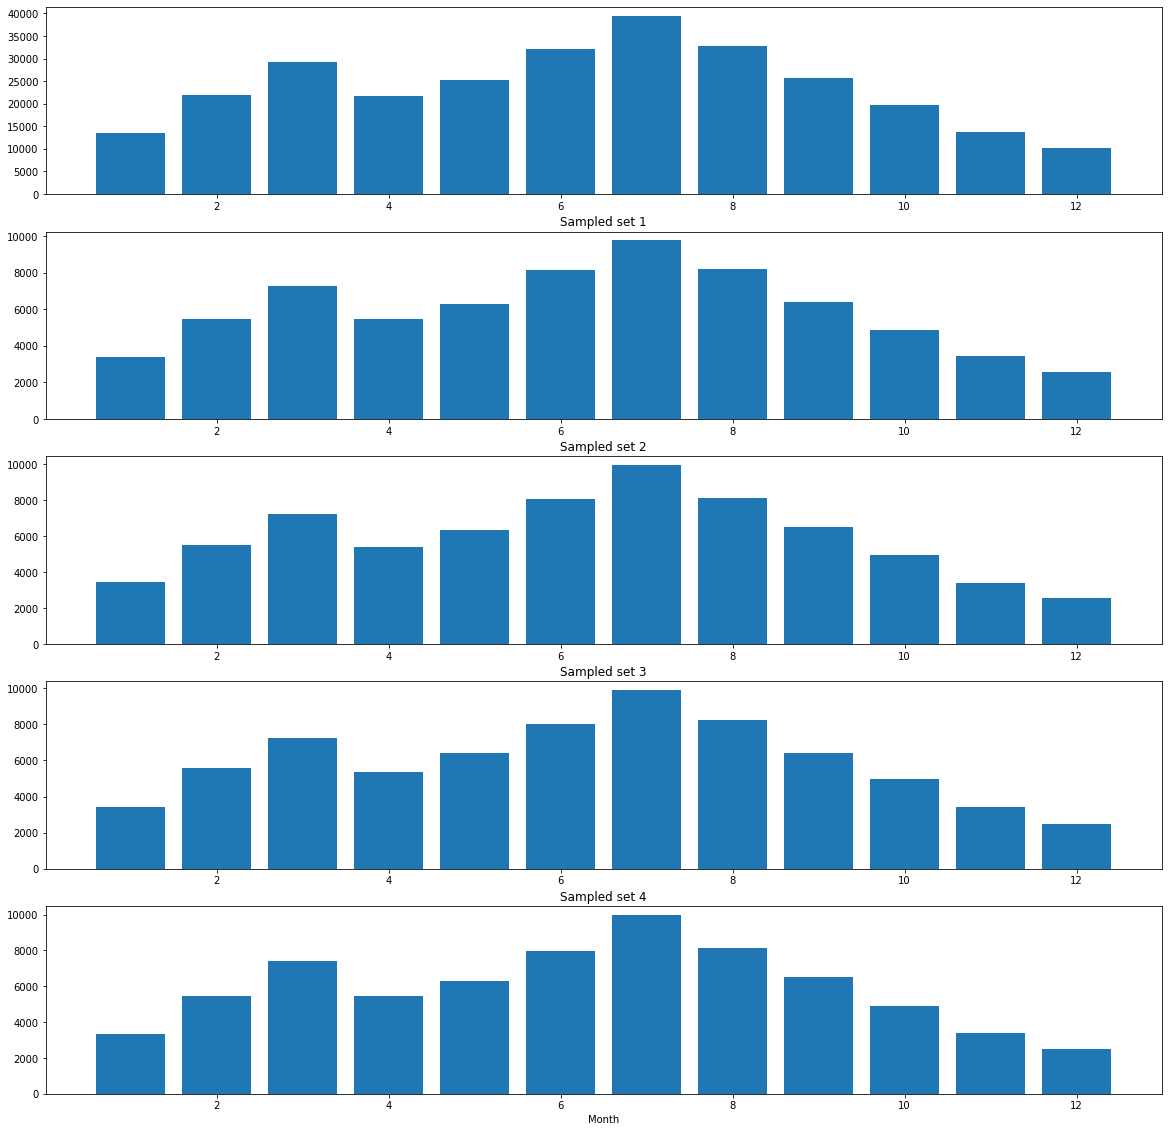

In [28]:
#@title
# Prevalance by Month
print(train_df["DATE"].dt.month)
fig, axs = plt.subplots(num_sets+1, figsize=(20,20))

to_plot = np.array(train_df["DATE"].groupby(train_df["DATE"].dt.month).count())
axs[0].bar(range(1,len(to_plot)+1), to_plot)

for i in range(num_sets):
  to_plot = np.array(sets[i]["DATE"].groupby(sets[i]["DATE"].dt.month).count())
  axs[i+1].bar(range(1,len(to_plot)+1), to_plot)
  axs[i+1].set_title('Sampled set %i'%(i+1), fontsize=12)

plt.xlabel("Month")

<ipython-input-29-0041ec2037b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sets[i]["DATE"] = train_df["DATE"].astype("datetime64")


Text(0.5, 0, 'Year')

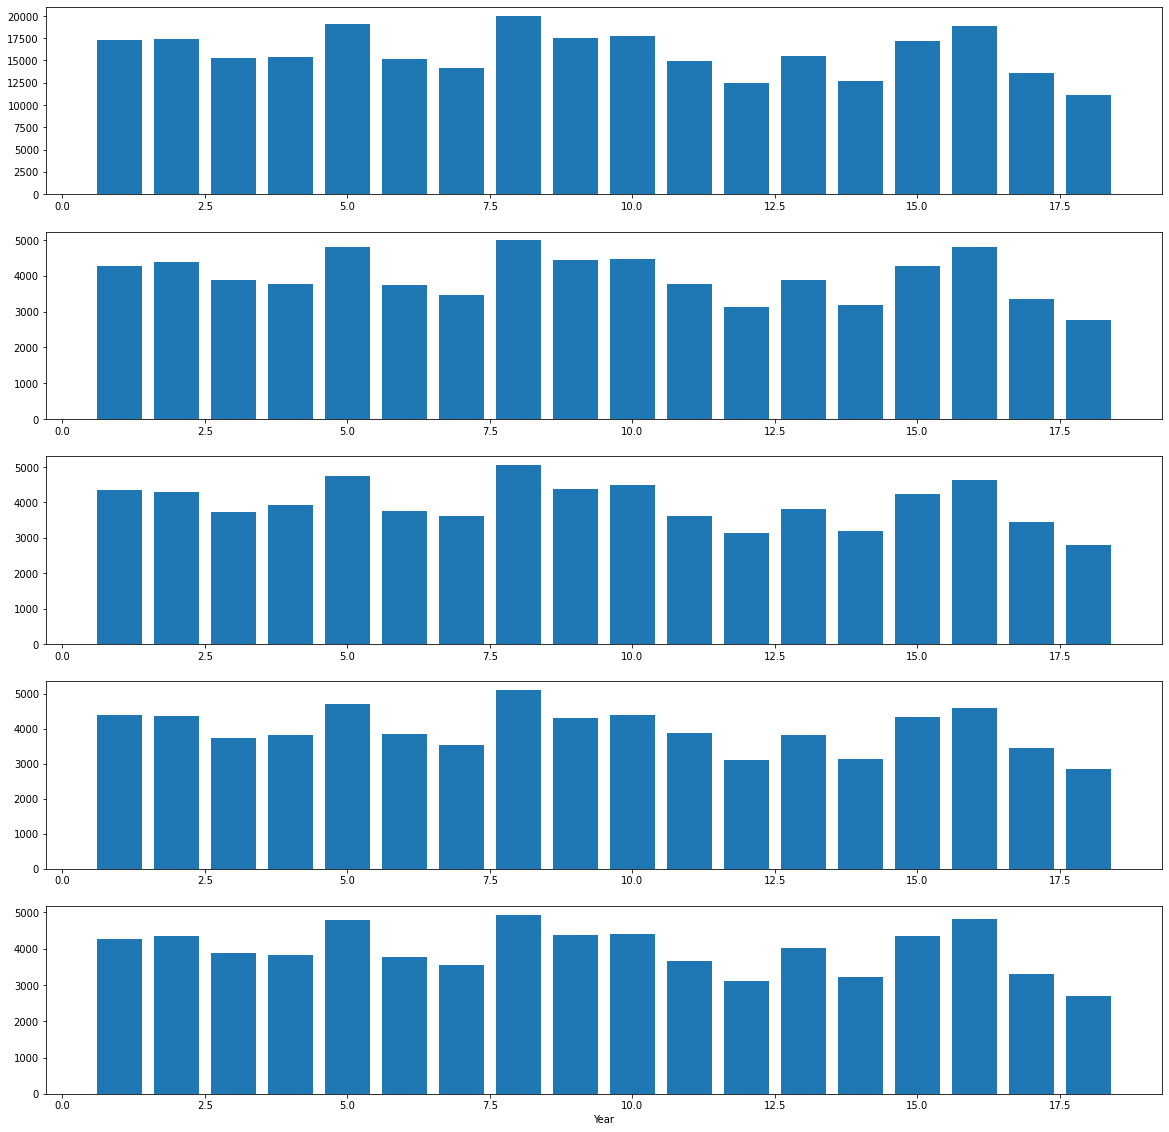

In [29]:
#@title
# Prevalance by Year
fig, axs = plt.subplots(num_sets+1, figsize=(20,20))

train_df["DATE"] = train_df["DATE"].astype("datetime64")
to_plot = np.array(train_df["DATE"].groupby(train_df["DATE"].dt.year).count())
axs[0].bar(range(1,len(to_plot)+1), to_plot)

for i in range(num_sets):
  sets[i]["DATE"] = train_df["DATE"].astype("datetime64")
  to_plot = np.array(sets[i]["DATE"].groupby(sets[i]["DATE"].dt.year).count())
  axs[i+1].bar(range(1,len(to_plot)+1), to_plot)

plt.xlabel("Year")

Text(0.5, 0, 'Day')

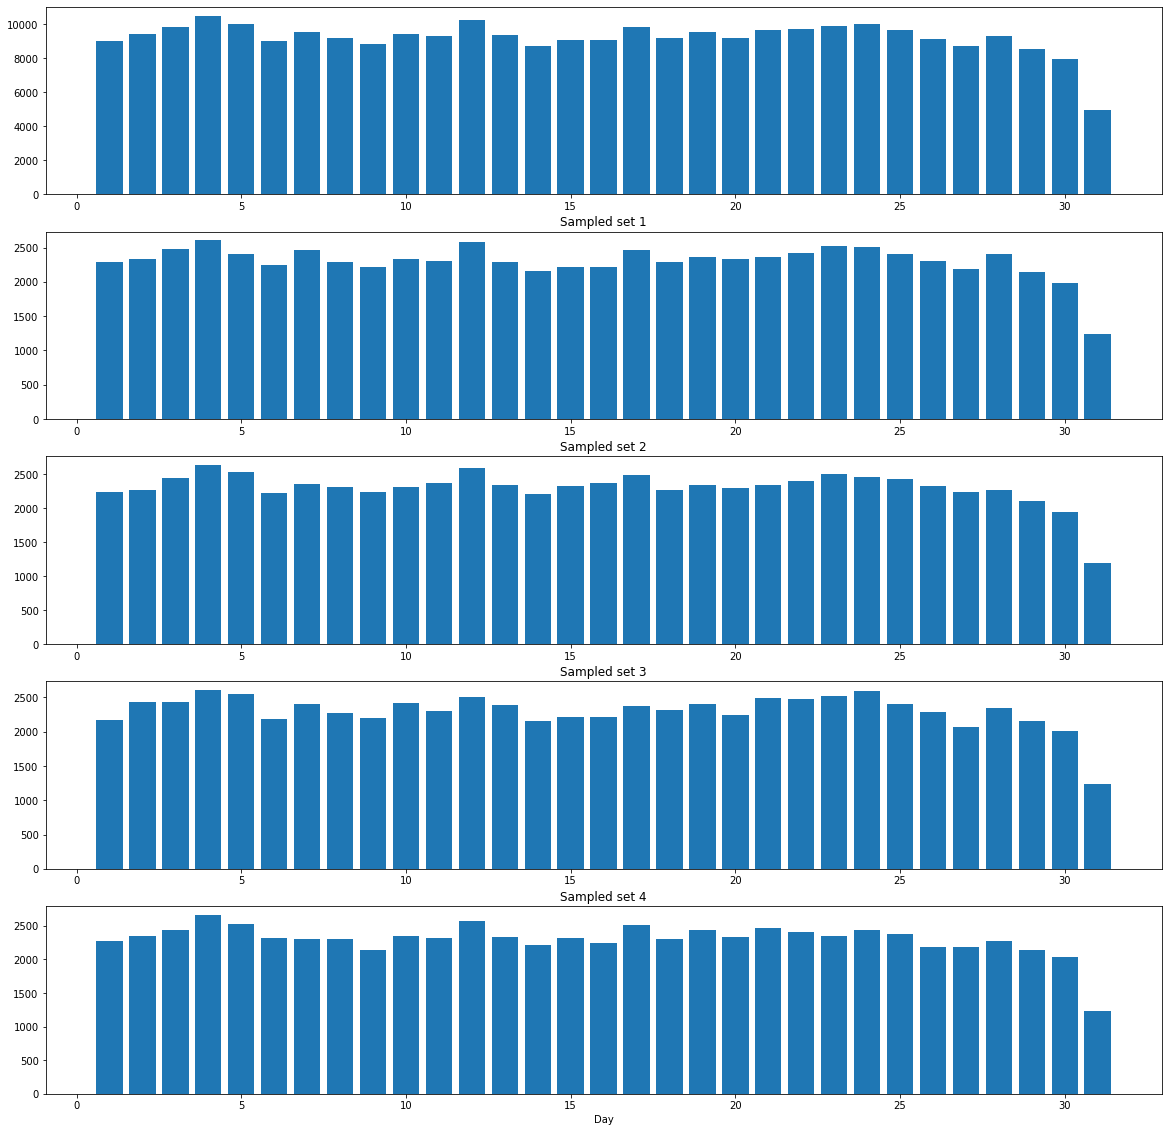

In [30]:
#@title
# Prevalance by Day
fig, axs = plt.subplots(num_sets+1, figsize=(20,20))

to_plot = np.array(train_df["DATE"].groupby(train_df["DATE"].dt.day).count())
axs[0].bar(range(1,len(to_plot)+1), to_plot)

for i in range(num_sets):
  to_plot = np.array(sets[i]["DATE"].groupby(sets[i]["DATE"].dt.day).count())
  axs[i+1].bar(range(1,len(to_plot)+1), to_plot)
  axs[i+1].set_title('Sampled set %i'%(i+1), fontsize=12)

plt.xlabel("Day")

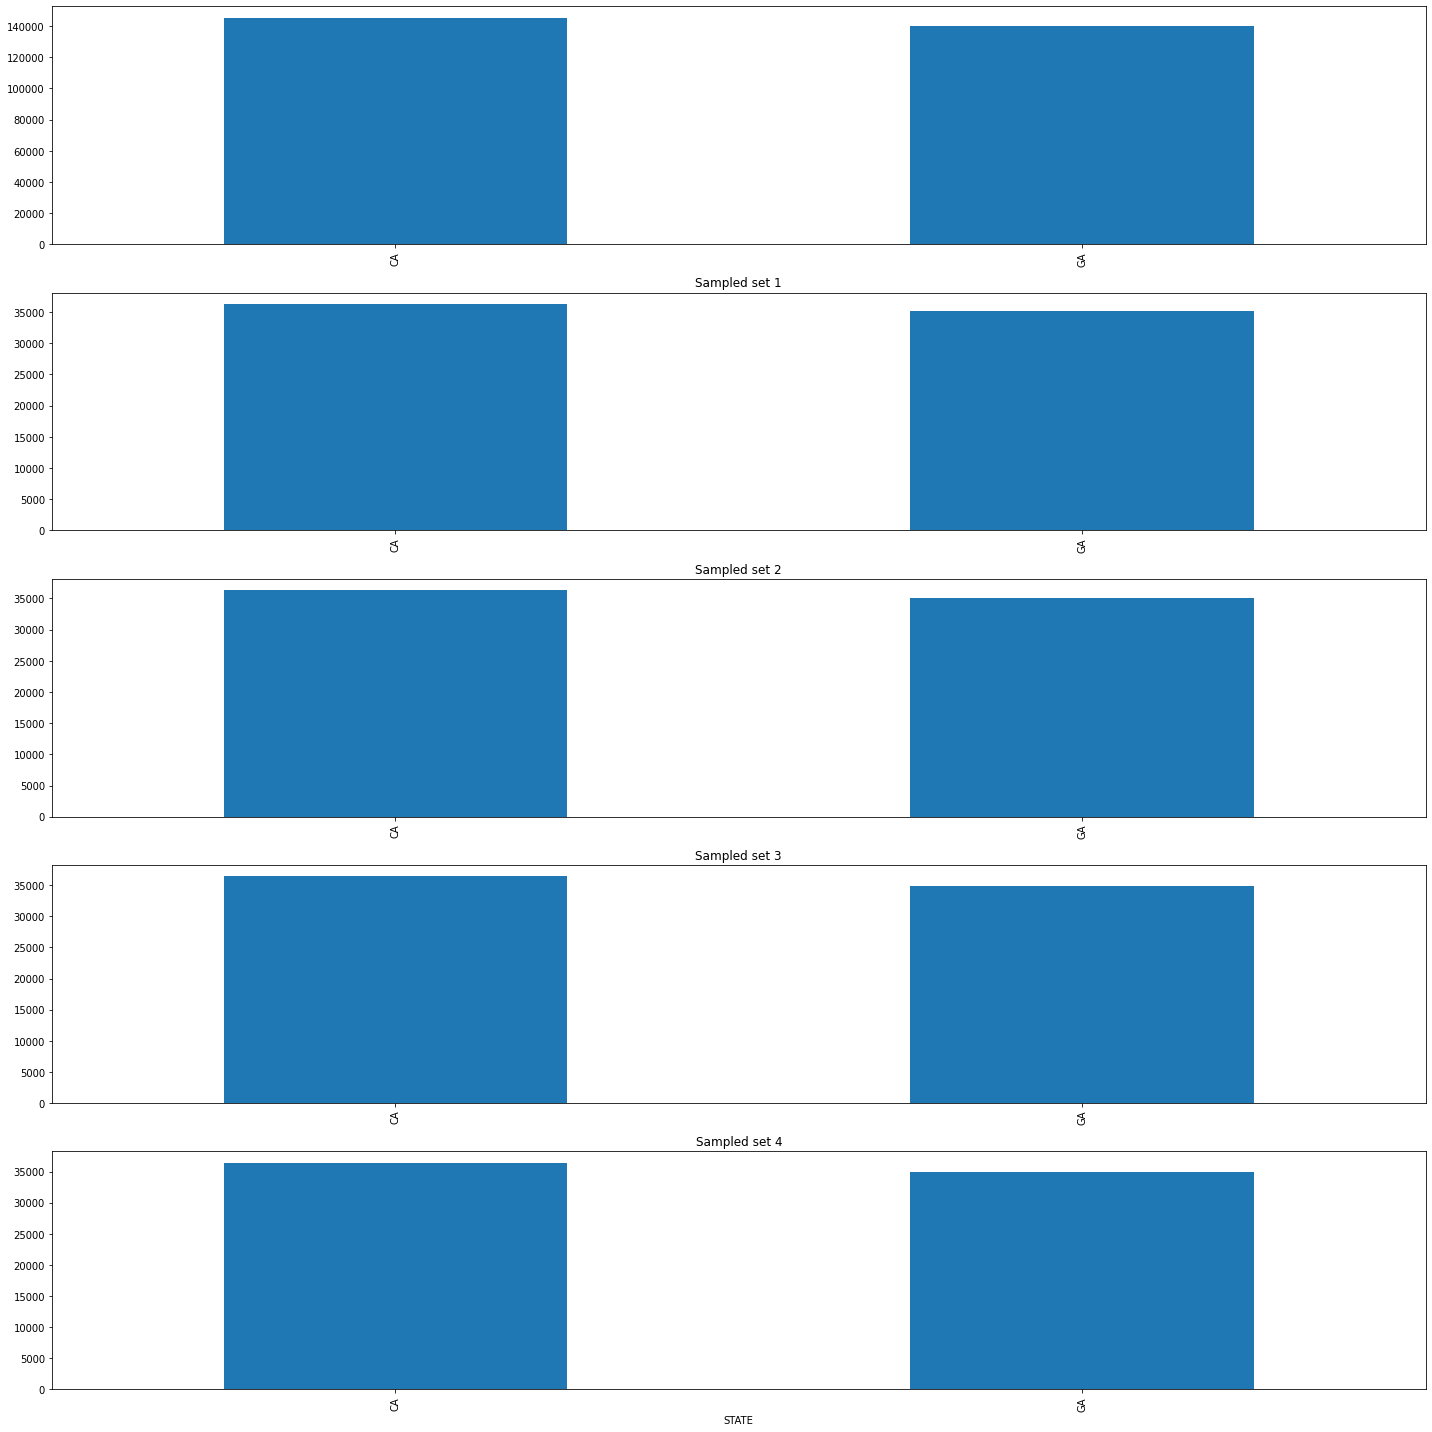

In [31]:
#@title
feature = 'STATE'

# Prevalance by State
fig, axs = plt.subplots(num_sets+1, figsize=(20,20))
train_df[feature].value_counts().plot(kind='bar', ax=axs[0])

for i in range(num_sets):
  sets[i][feature].value_counts().plot(kind='bar', ax=axs[i+1])
  axs[i+1].set_title('Sampled set %i'%(i+1), fontsize=12)

plt.xlabel(feature)

plt.tight_layout()
plt.show()  

In [32]:
#@title
feature = 'FIPS_NAME'

# Prevalance by FIPS_NAME
fig, axs = plt.subplots(num_sets+1, figsize=(100,100))
train_df[feature].value_counts().plot(kind='bar', ax=axs[0])

for i in range(num_sets):
  sets[i][feature].value_counts().plot(kind='bar', ax=axs[i+1])

plt.xlabel(feature)

plt.tight_layout()
plt.show()  

In [ ]:
#@title
feature = "SOURCE_REPORTING_UNIT_NAME"

# Prevalance by SOURCE_REPORTING_UNIT_NAME
fig, axs = plt.subplots(num_sets+1, figsize=(100,100))
train_df[feature].value_counts().plot(kind='bar', ax=axs[0])

for i in range(num_sets):
  sets[i][feature].value_counts().plot(kind='bar', ax=axs[i+1])

plt.xlabel(feature)

plt.tight_layout()
plt.show()  

In [ ]:
def dateTransform(data):
    """
    This function transforms the date feature to a two arrays year and day of year,
    taking into account leap years to produce a day from 1-366.
    
    Inputs:
        data: either a training or test data pandas dictionaries
    Output:
        year: (N, ) vector of years
        dayofyr: (N, ) vector of days of the year ranging from 1 to 366
    """
    year= np.array(data["DATE"].dt.year)
    d = np.array(data["DATE"].dt.day)
    mo = np.array(data["DATE"].dt.month)
    daysinmos = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    daysinmos2 = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dayofyr = np.copy(d)
    for i in range(len(year)):
      if mo[i]!=1:  
        if year[i]%4==0:
          dayofyr[i]=np.sum(daysinmos2[0:(mo[i]-1)])+d[i]
        else:
          dayofyr[i]=np.sum(daysinmos[0:(mo[i]-1)])+d[i]
    return year, dayofyr
        

In [ ]:
#@title
#Test dateTransform function --- works
year= np.array([2004, 2004, 2005, 2021])
d = np.array([2, 3, 3, 30])
mo = np.array([1, 3, 3, 4])
daysinmos = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
daysinmos2 = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
dayofyr = np.copy(d)
for i in range(len(year)):
  if mo[i]!=1:  
    if year[i]%4==0:
       dayofyr[i]=np.sum(daysinmos2[0:(mo[i]-1)])+d[i]
    else:
      dayofyr[i]=np.sum(daysinmos[0:(mo[i]-1)])+d[i]
print(year)
print(dayofyr)

[2004 2004 2005 2021]
[  2  63  62 120]


In [16]:
#Transform date data
test_year, test_dayofyr = dateTransform(test_df)
train_year, train_dayofyr = dateTransform(train_df)


NameError: name 'dateTransform' is not defined

In [93]:
#Running kmeans and plotting
def k_means(data_set, k=5, cluster_names = ['LONGITUDE', 'LATITUDE'], plot_fig_flag=0, save_fig_flag=0):
    """
    Purpose:
        Take in a pandas dataframe. Parse out longitude and latitude and output classifications and plots
    Inputs:
        data_set (pandas df)         : 
        k        (int)               : Number of clusters
        cluster_name (list of strings): Contains the names for which to cluster over (Must be in dataframe) (M clusters)
        
    Outputs:
        labels - Classification of points (N x 1)
        class_cent - classification centers               (k x M)
        
    """
    #Initialize array for storing data
    N = len(data_set[cluster_names[0]])
    X = np.zeros((N,len(cluster_names)))
    
    #Put data into coordinate matrix (X)
    for i, name_i in enumerate(cluster_names):
        data_i = data_set[name_i].to_numpy()
        X[:,i] = data_i

    #Run kmeans
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    
    #Plot
    if plot_fig_flag:
        # Error checking
        if len(cluster_names) != 2:
            #NOTE This could be extended using PCA to plot higher dims
            #https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
            raise Exception('We can only plot 2-D data for now')
        
        #Mesh step size
        h = .02 
        
        #Form our mesh for plotting
        x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
        y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Obtain labels for each point in mesh. Use last trained model.
        Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(1)
        plt.clf()
        plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

        plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
        # Plot the centroids as a white X
        centroids = kmeans.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
        plt.title("K-means clustering\n"
                  "Centroids are marked with white cross")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        
        if save_fig_flag:
            #TODO Make this name more robust. Show cluster names and k.
            plt.save_fig('kmeans_plot.png')
        
        plt.show()
        
        
    return kmeans.labels_, kmeans.cluster_centers_

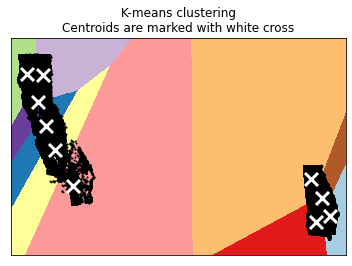

In [96]:
#Visualize k-means
labels, centers = k_means(train_df,k=10, cluster_names = ['LONGITUDE', 'LATITUDE'], plot_fig_flag=1, save_fig_flag=0)
